In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from PIL import Image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
sample_submission_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")
transactions_train_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")



In [3]:
import pandas as pd

transactions_train_df['customer_id'] =\
    transactions_train_df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')#try



transactions_train_df['article_id'] = transactions_train_df['article_id'].astype('int32')

transactions_train_df['article_id'] = '0' + transactions_train_df.article_id.astype('str')



transactions_train_df['price'] = transactions_train_df['price'].astype('float32')
transactions_train_df['sales_channel_id'] = transactions_train_df['sales_channel_id'].astype('int8')


In [4]:
#articles - contains informations about each article (like product code, name, product group code, name ...)
articles_df.head()
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [5]:
#customers - contains informations about each customer (fidelity card membership, age, postal code)
#postal_code is not correct , maybe we should remove it
customers_df.head()
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [6]:
#Transactions have customer_id and article_id, which are foreign keys for 
#the customer and articles tables. Beside this, transaction also contains sales_channel_id
transactions_train_df.head()
transactions_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       int64  
 2   article_id        object 
 3   price             float32
 4   sales_channel_id  int8   
dtypes: float32(1), int64(1), int8(1), object(2)
memory usage: 879.2+ MB


# Exploratory Data Analysis

**1. Check the missing value and what is the percentage of missing value in each feature.**

**2. Check how many unique observation in each feature.**

In [7]:
#Check the missing value and what is the percentage of missing value in each feature for customers data
#There is no missing value in customer_id and in postal_code ; club_member_status only has 0.4% missing value
#The feature of fashion_news_frequency and age contain round 1% missing values.
#The feature of Active and FN contains around 65 % missing value.

def missing_val_perc(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    return pd.concat([total,percent], axis = 1 , keys = ["total","%"])

missing_val_perc(customers_df)
#total1 = customers_df.isnull().sum().sort_values(ascending = False)
#percent1 = (customers_df.isnull().sum()/customers_df.isnull().count()*100).sort_values(ascending = False)
#df_isnull1 = pd.concat([total,percent],axis = 1,keys = ["total","percent"])
#df_isnull1

,total,%
customer_id,0,0.000000
FN,895050,65.237831
Active,907576,66.150819
club_member_status,6062,0.441843
fashion_news_frequency,16009,1.166854
age,15861,1.156066
postal_code,0,0.000000


In [8]:
#Check the missing value and what is the percentage of missing value in each feature for articles data
#The only one feature that has missing value is detail_desc which contains 0.4% missing values

missing_val_perc(articles_df)

,total,%
article_id,0,0.000000
product_code,0,0.000000
prod_name,0,0.000000
product_type_no,0,0.000000
product_type_name,0,0.000000
product_group_name,0,0.000000
graphical_appearance_no,0,0.000000
graphical_appearance_name,0,0.000000
colour_group_code,0,0.000000
colour_group_name,0,0.000000


In [9]:
#Check the missing value and what is the percentage of missing value in each feature for transactions_train data
#There is no missing value in this dataset 

missing_val_perc(transactions_train_df)

,total,%
t_dat,0,0.0
customer_id,0,0.0
article_id,0,0.0
price,0,0.0
sales_channel_id,0,0.0


In [10]:
#Check how many unique observation in each feature. 

def unique(data):
    total = data.count()
    df = pd.DataFrame (total)
    df.columns = ["total"]

    lst = []
    for col in data.columns:
        unique = len(data[col].unique())
        lst.append(unique)
    df['unique']= lst

    return df  


unique(articles_df)

,total,unique
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131
product_group_name,105542,19
graphical_appearance_no,105542,30
graphical_appearance_name,105542,30
colour_group_code,105542,50
colour_group_name,105542,50


In [11]:
unique(customers_df)


,total,unique
customer_id,1371980,1371980
FN,476930,2
Active,464404,2
club_member_status,1365918,4
fashion_news_frequency,1355971,5
age,1356119,85
postal_code,1371980,352899


In [12]:
unique(transactions_train_df)

,total,unique
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


**EDA -  Article Data**

**Check the how many obserations for each feature  in Article Data**

In [13]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [14]:
unique(articles_df)

,total,unique
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131
product_group_name,105542,19
graphical_appearance_no,105542,30
graphical_appearance_name,105542,30
colour_group_code,105542,50
colour_group_name,105542,50


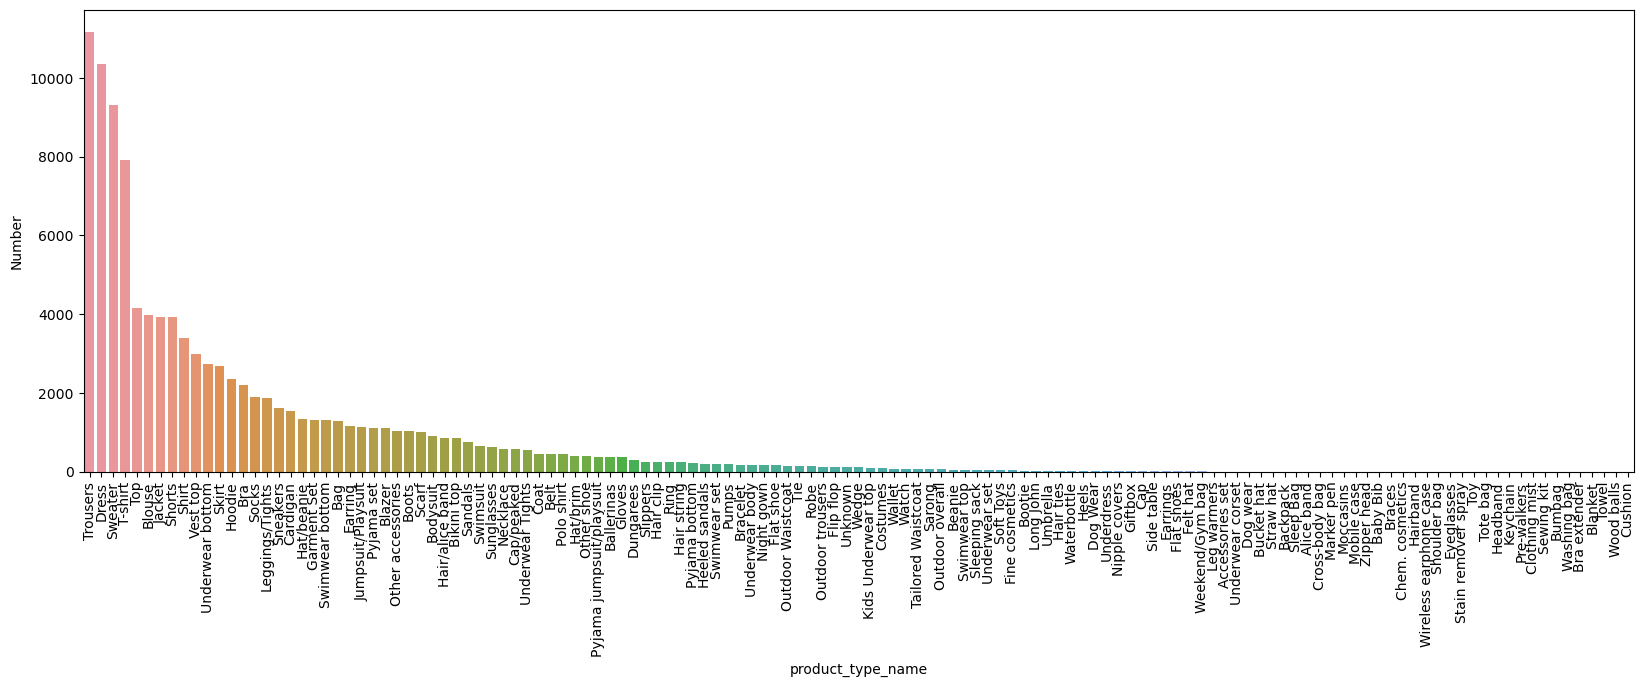

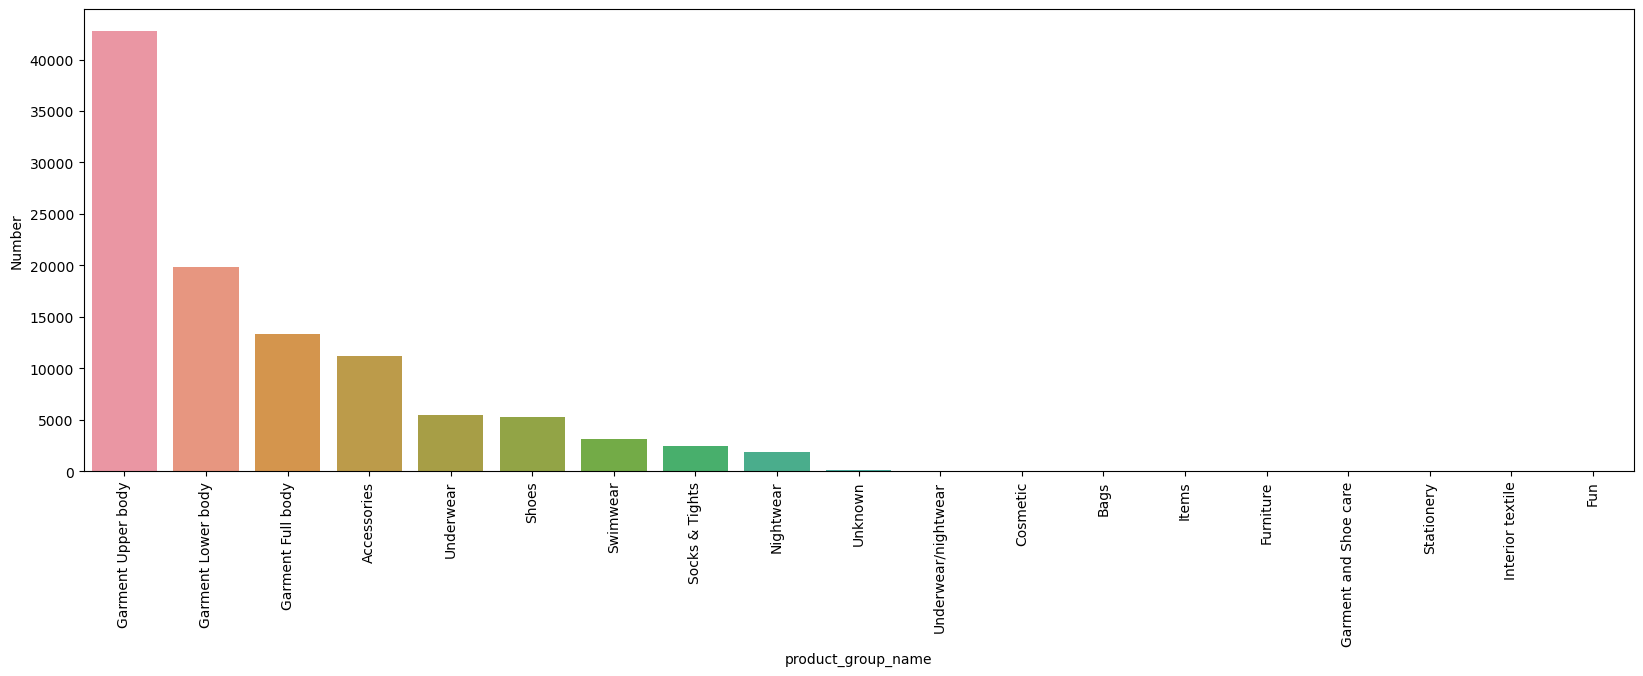

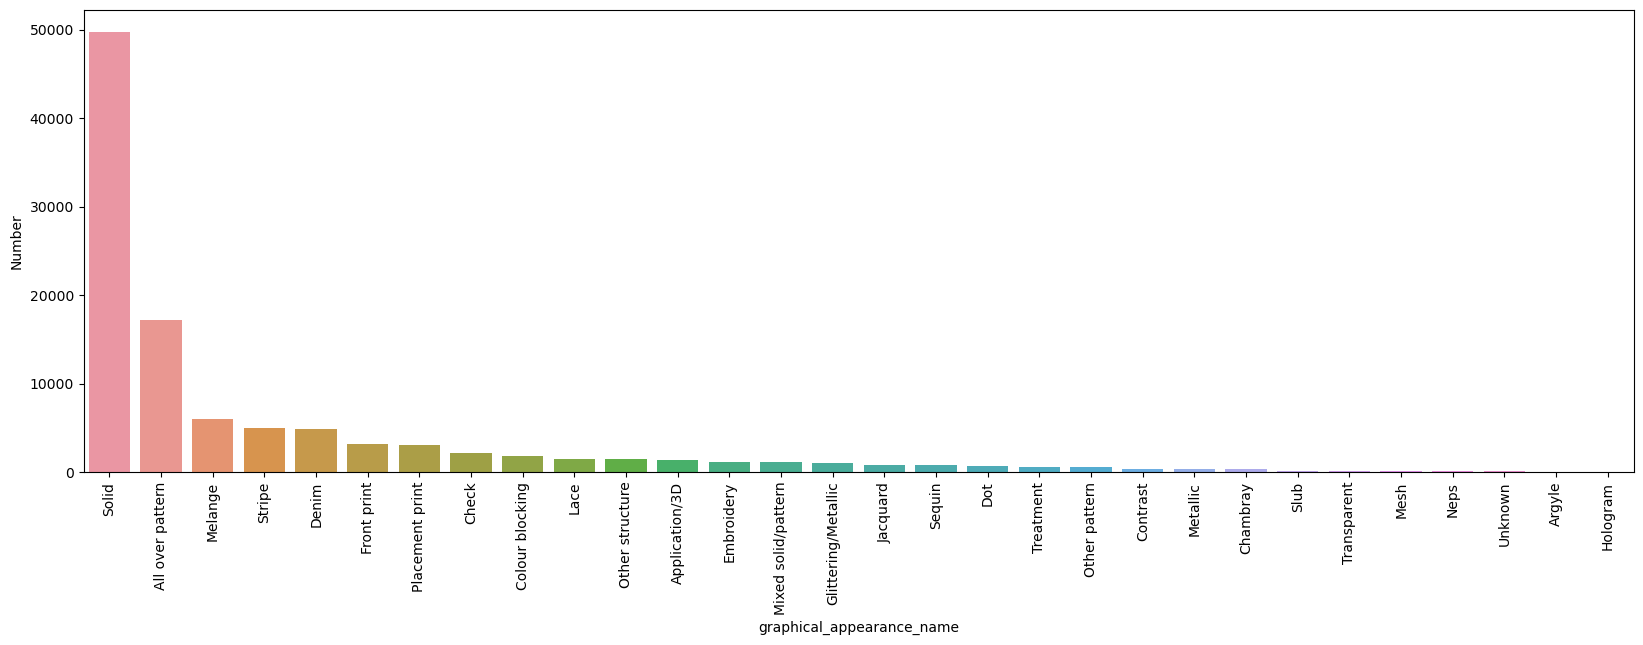

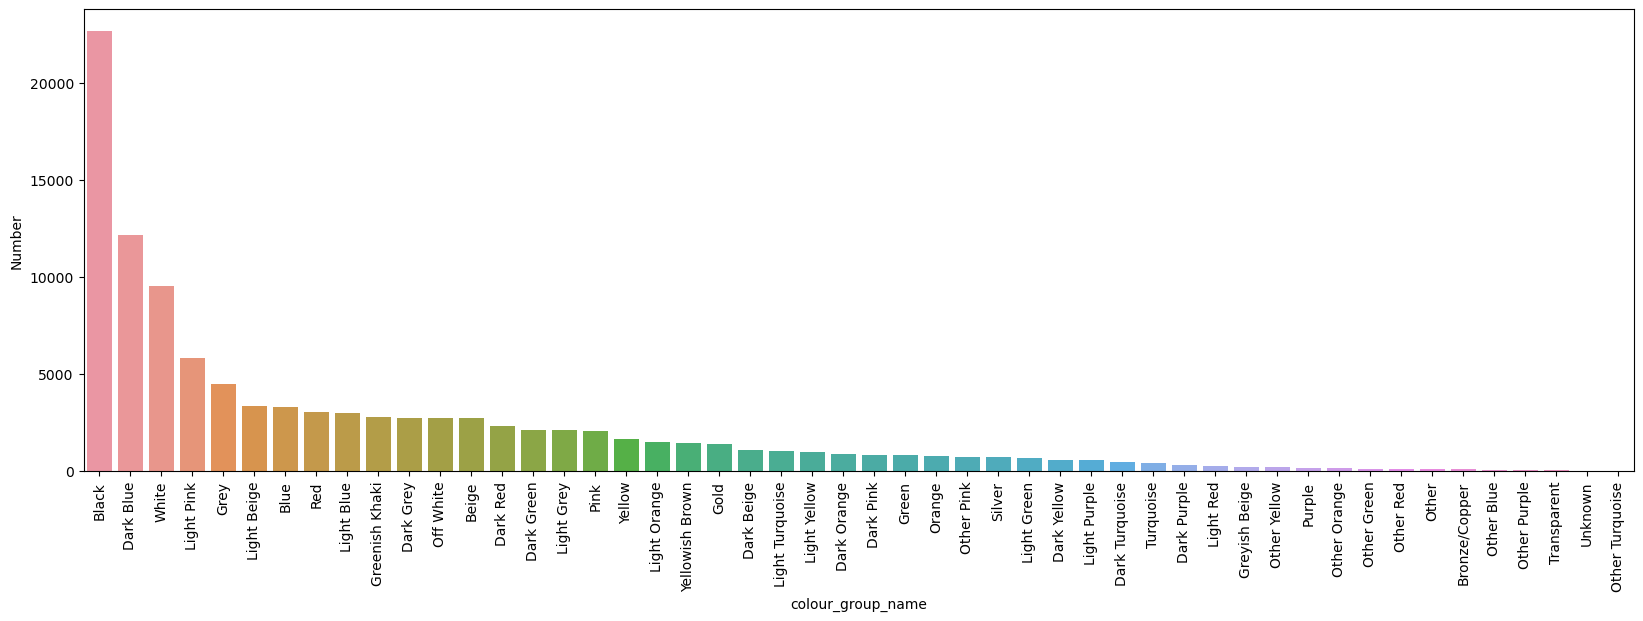

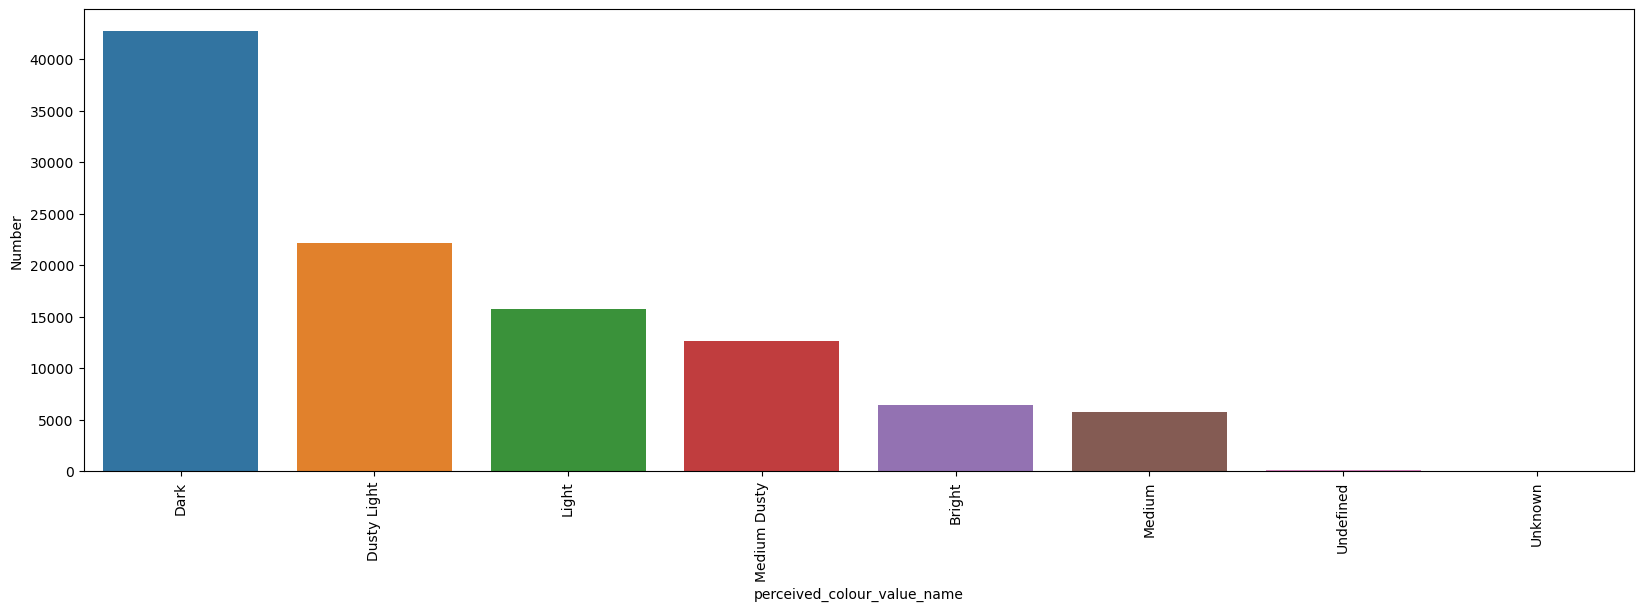

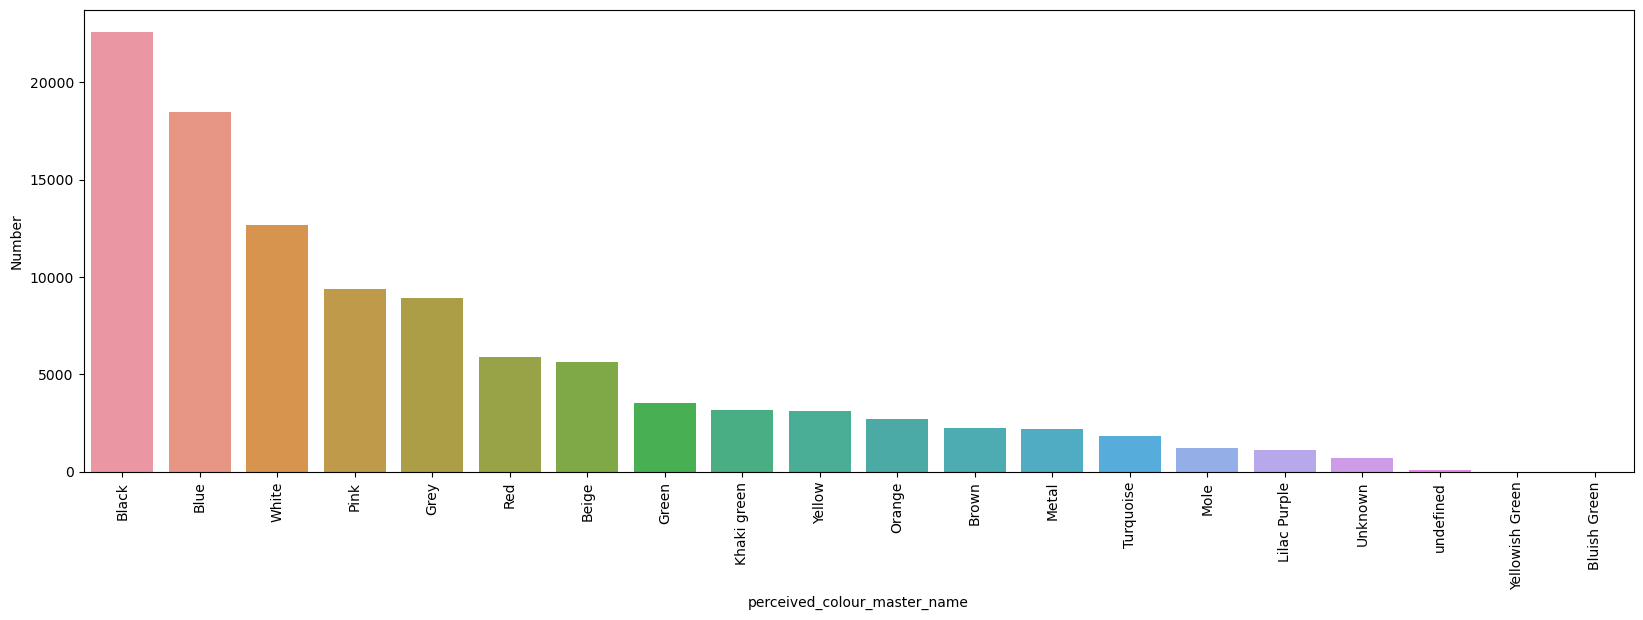

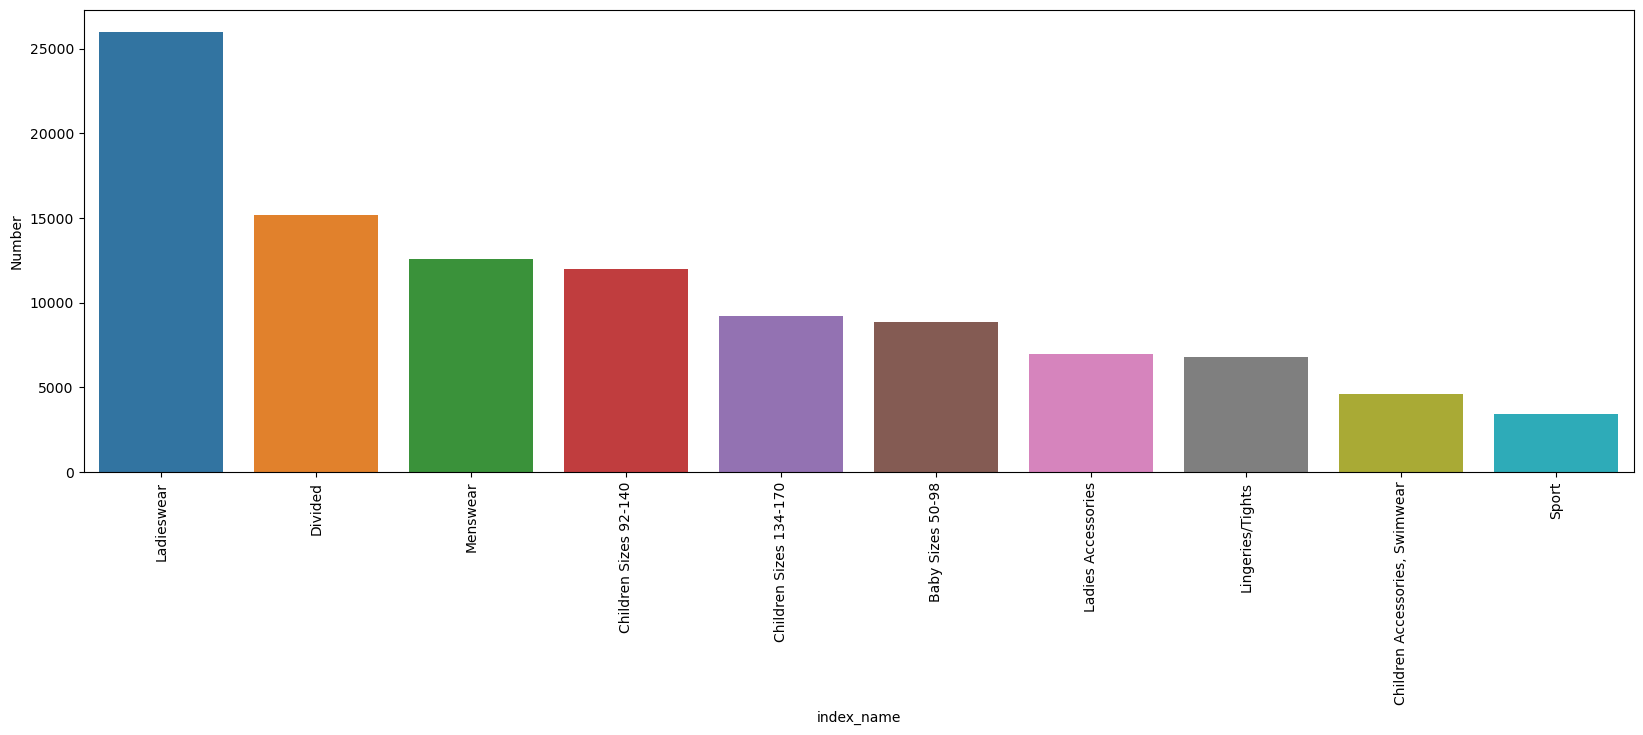

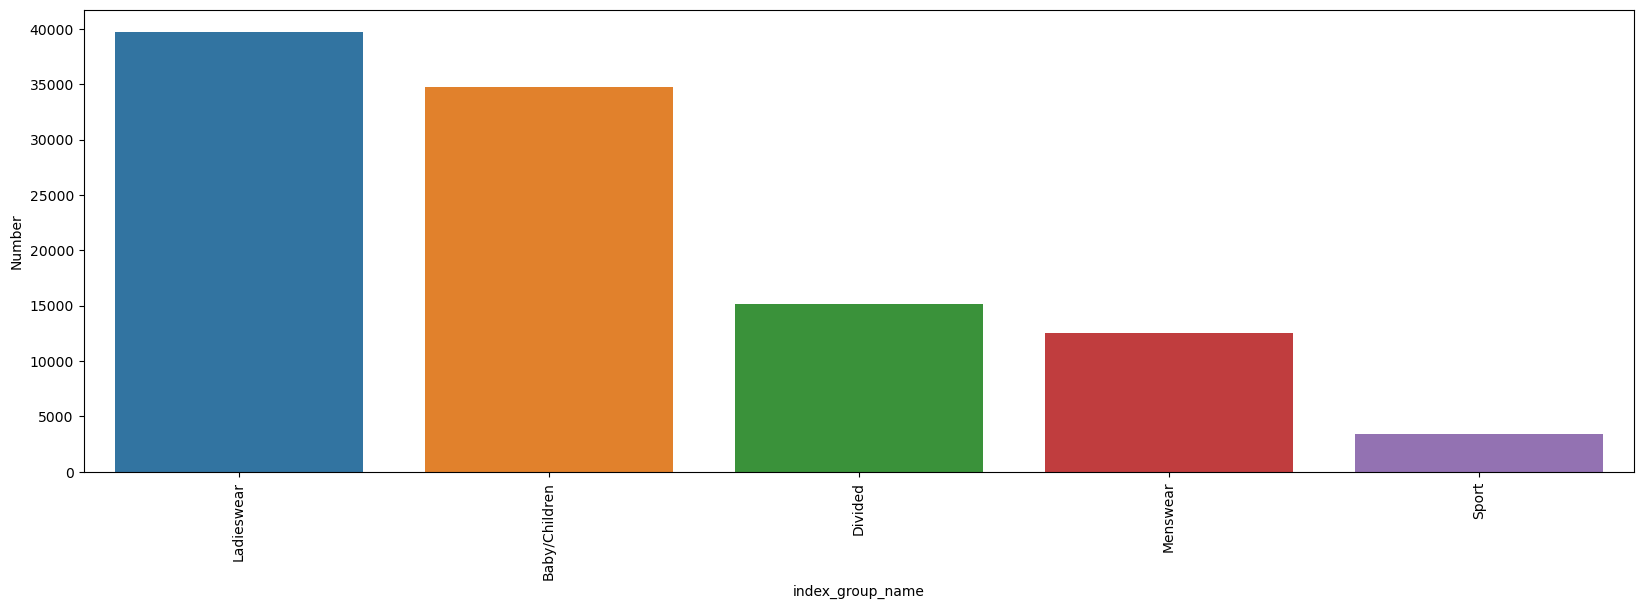

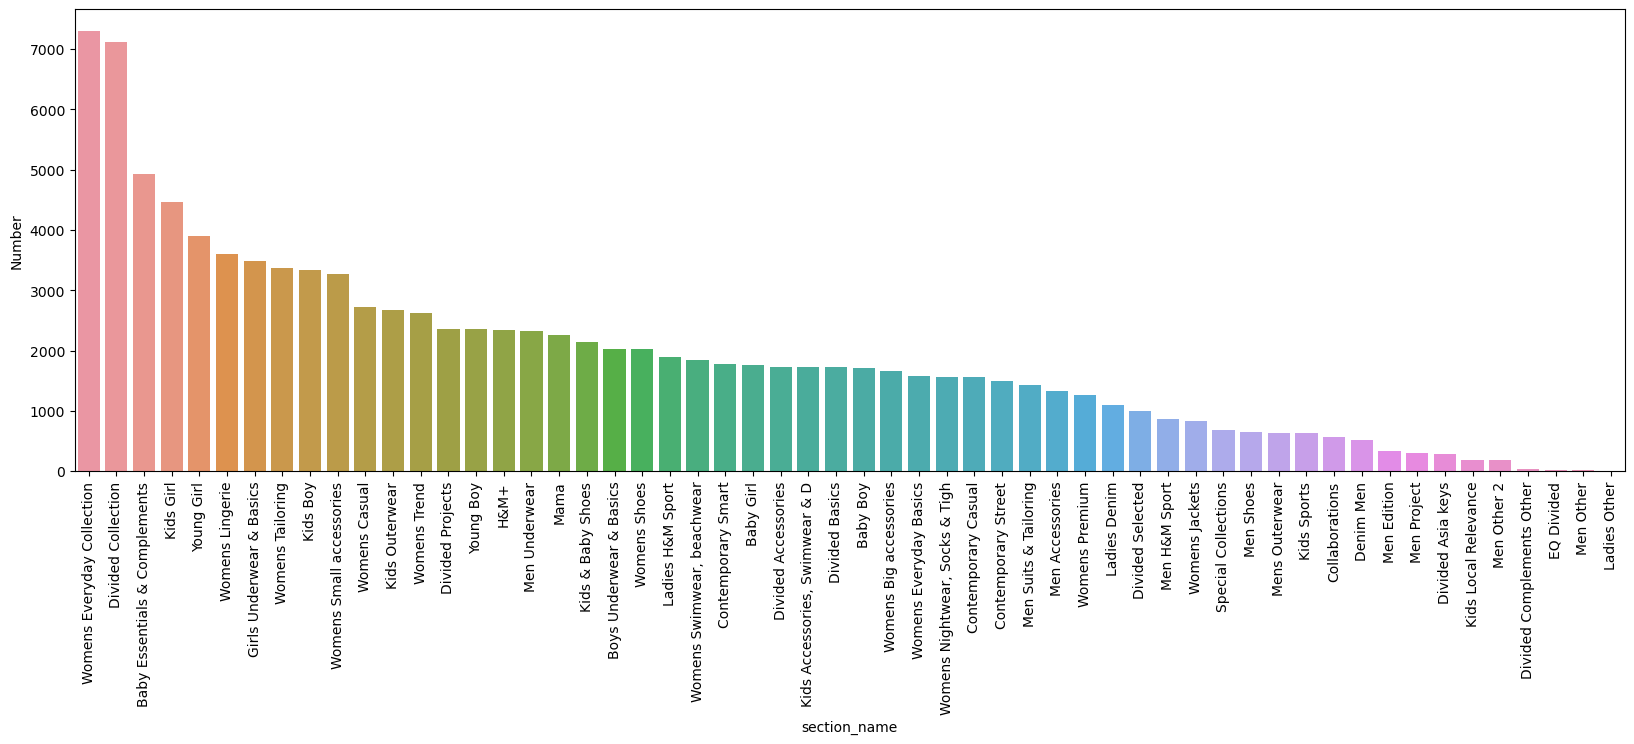

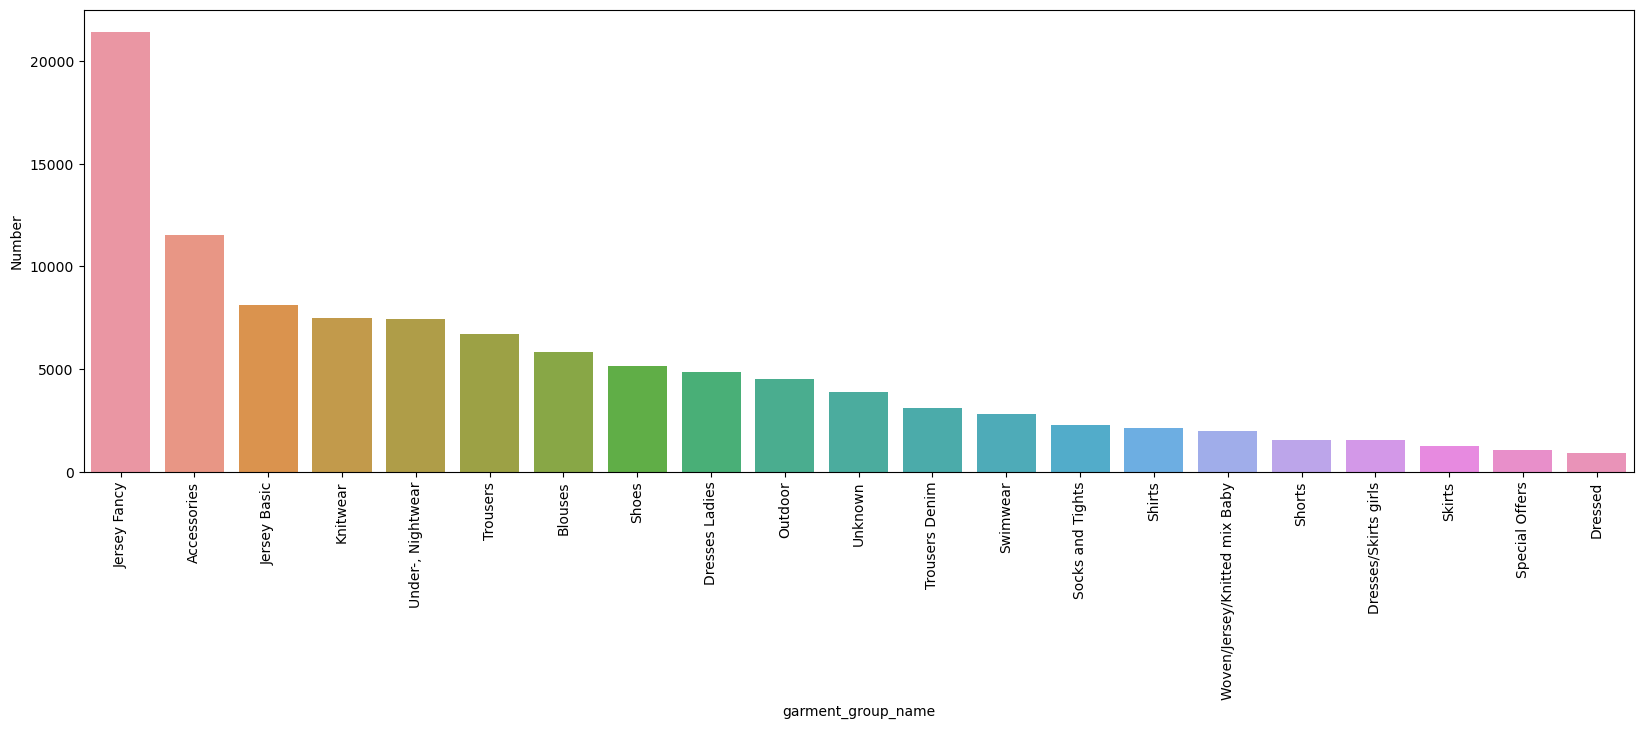

In [15]:


lst_article = ["product_type_name","product_group_name","graphical_appearance_name","colour_group_name",
              "perceived_colour_value_name","perceived_colour_master_name","index_name","index_group_name",
              "section_name","garment_group_name"]


for col in lst_article :
    group1 =articles_df.groupby([col])["article_id"].nunique()
    df1 = pd.DataFrame({col:group1.index,"Number":group1.values})
    df1=df1.sort_values(["Number"], ascending=False)
    plt.figure(figsize = (20,6))
    plt.title = "Amount in each product group "
    ax = sns.barplot(x= col, y="Number", data =df1  )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

**EDA -  Customer Data**

**Check the how many obserations for each feature  in Customer**

In [16]:
unique(customers_df)

,total,unique
customer_id,1371980,1371980
FN,476930,2
Active,464404,2
club_member_status,1365918,4
fashion_news_frequency,1355971,5
age,1356119,85
postal_code,1371980,352899


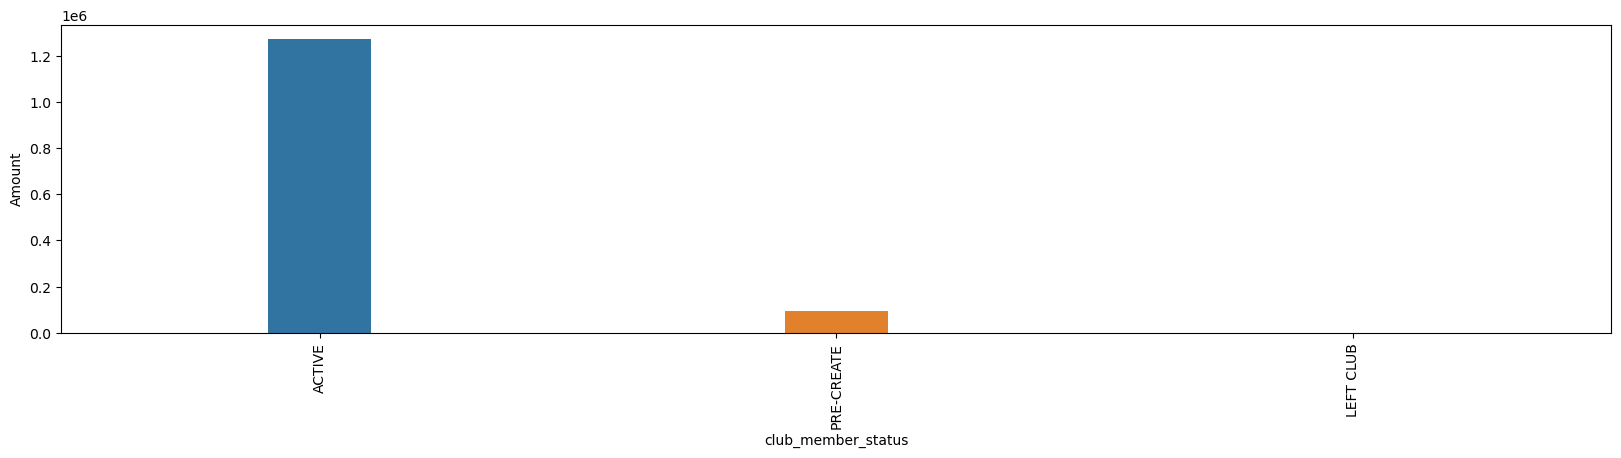

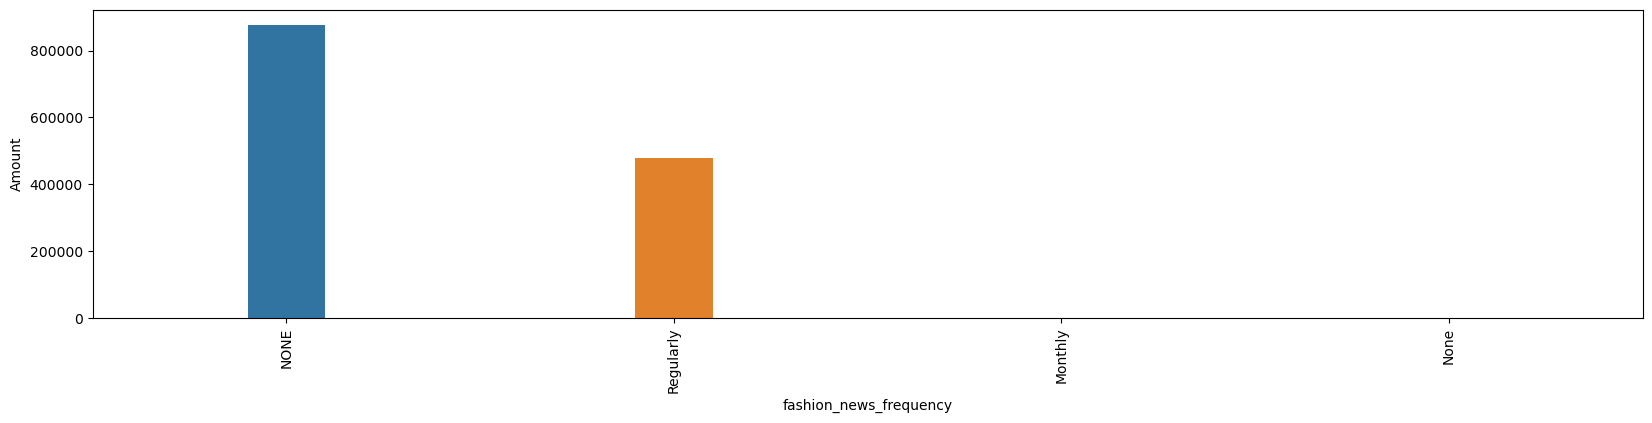

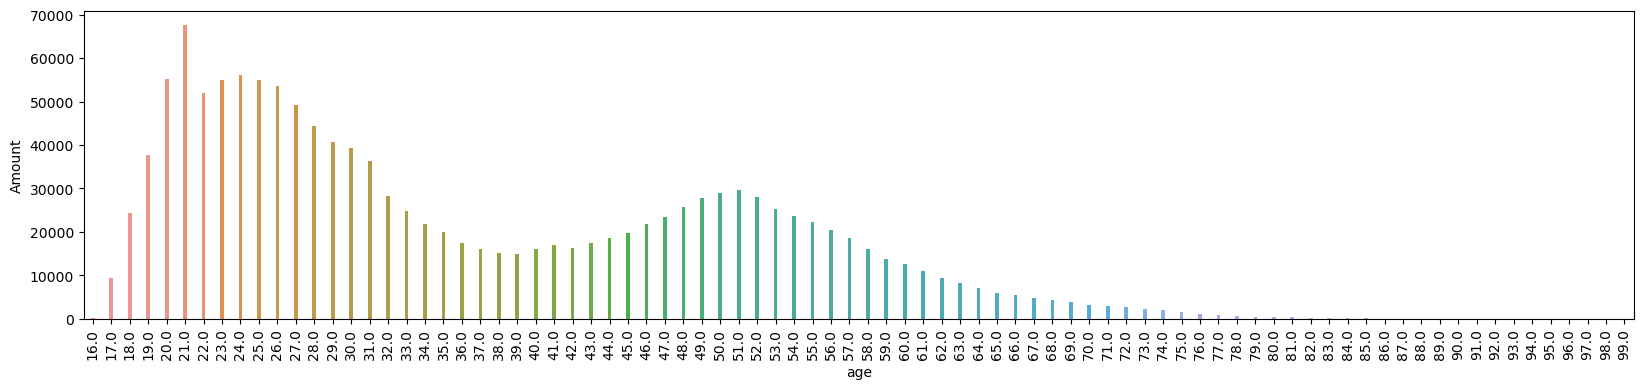

In [17]:
lst_cutomer = ["club_member_status","fashion_news_frequency","age"]
for col2 in lst_cutomer:
    group2 = customers_df.groupby([col2])["customer_id"].nunique()
    group2_df = pd.DataFrame({col2:group2.index,"Amount":group2.values})
    group2_df=group2_df.sort_values(["Amount"],ascending=False)
    plt.figure(figsize = (20,4))
    plt.title = "Amount of observation in each catagory"
    axes2 = sns.barplot(x= col2, y = "Amount", data =group2_df,width=.2 )
    axes2.set_xticklabels(axes2.get_xticklabels(),rotation=90)
    plt.show()

**EDA -  Transaction Data**
​


In [18]:
unique(transactions_train_df)

,total,unique
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


In [19]:
transactions_train_df

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,0663713001,0.050831,2
1,2018-09-20,-6846340800584936,0541518023,0.030492,2
2,2018-09-20,-8334631767138808638,0505221004,0.015237,2
3,2018-09-20,-8334631767138808638,0685687003,0.016932,2
4,2018-09-20,-8334631767138808638,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,0929511001,0.059305,2
31788320,2020-09-22,4685485978980270934,0891322004,0.042356,2
31788321,2020-09-22,3959348689921271969,0918325001,0.043203,1
31788322,2020-09-22,-8639340045377511665,0833459002,0.006763,1


In [20]:
# sampling 30,000 from 31,788,323 observations 

new_df = transactions_train_df.sample(30000, replace=False).sort_values(["t_dat"])
new_df1 = new_df.groupby(["t_dat"])["article_id"].count()

new_df2 = pd.DataFrame({"Date":new_df1.index,"Volumns":new_df1.values})
new_df2 

,Date,Volumns
0,2018-09-20,36
1,2018-09-21,41
2,2018-09-22,13
3,2018-09-23,38
4,2018-09-24,47
...,...,...
729,2020-09-18,37
730,2020-09-19,35
731,2020-09-20,21
732,2020-09-21,37


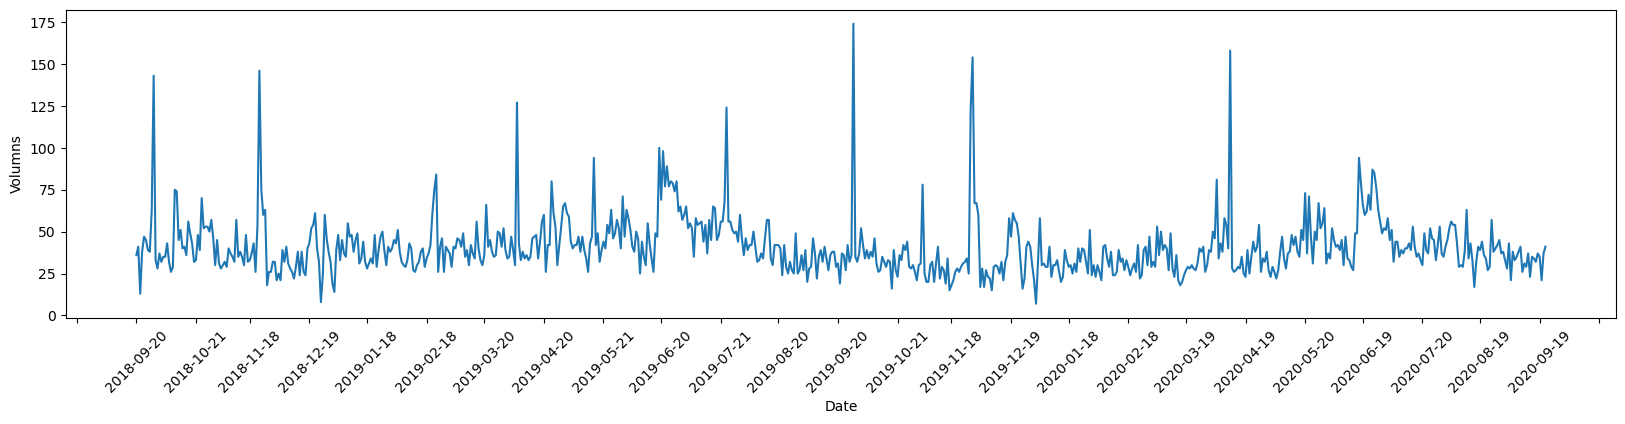

In [21]:
#sales volumn per data
import matplotlib.dates as mdates


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize = (20,4))
plt.title = "Amount of observation in each catagory"
axes3 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df2 )
locator = mdates.MonthLocator()
axes3.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.show()



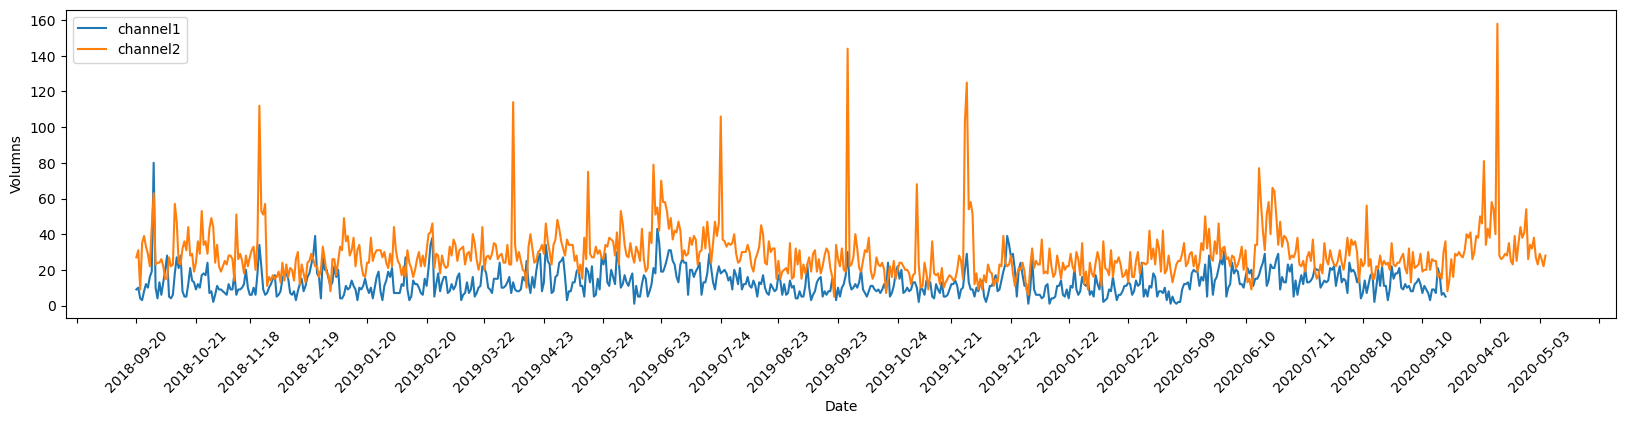

In [22]:
#plot daily sales volumns of each channel

channel1 = new_df[new_df["sales_channel_id"]==1]
channel2 = new_df[new_df["sales_channel_id"]==2]

new_df3 = channel1.groupby(["t_dat"])["article_id"].count()
new_df4 = pd.DataFrame({"Date":new_df3.index,"Volumns":new_df3.values})

new_df5 = channel2.groupby(["t_dat"])["article_id"].count()
new_df6 = pd.DataFrame({"Date":new_df5.index,"Volumns":new_df5.values})

plt.figure(figsize = (20,4))
plt.title = "Amount of observation in each catagory"
axes4 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df4 ,label="channel1" )
axes6 = sns.lineplot(x = "Date", y = "Volumns",
             data = new_df6 ,label="channel2" )
locator = mdates.MonthLocator()
axes4.xaxis.set_major_locator(locator)


plt.xticks(rotation=45)
plt.show()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
sns.set(rc = {'figure.figsize':(15,8)})

In [25]:
### Visualization for original dataset.
df = transactions_train_df['t_dat'].value_counts().rename_axis('date').reset_index(name='Purchases')
df.head()

,date,Purchases
0,2019-09-28,198622
1,2020-04-11,162799
2,2019-11-29,160875
3,2018-11-23,142018
4,2018-09-29,141700


In [26]:
df["Period"] = pd.to_datetime(df["date"])
df.head()

,date,Purchases,Period
0,2019-09-28,198622,2019-09-28
1,2020-04-11,162799,2020-04-11
2,2019-11-29,160875,2019-11-29
3,2018-11-23,142018,2018-11-23
4,2018-09-29,141700,2018-09-29


In [27]:
df = df.set_index("Period")
df

,date,Purchases
Period,,
2019-09-28,2019-09-28,198622
2020-04-11,2020-04-11,162799
2019-11-29,2019-11-29,160875
2018-11-23,2018-11-23,142018
2018-09-29,2018-09-29,141700
...,...,...
2019-01-01,2019-01-01,18145
2018-09-22,2018-09-22,17635
2018-12-25,2018-12-25,14799


In [28]:
df["year"] = df.index.year
df["Month"] = df.index.month_name()
df["month_number"] = df.index.month
df = df.sort_values('month_number')
df.head()

,date,Purchases,year,Month,month_number
Period,,,,,
2020-01-01,2020-01-01,12760,2020,January,1
2020-01-29,2020-01-29,36833,2020,January,1
2019-01-09,2019-01-09,53309,2019,January,1
2020-01-09,2020-01-09,36746,2020,January,1
2020-01-23,2020-01-23,36257,2020,January,1


[Text(0.5, 1.0, 'Purchases over the years 2018-2020')]

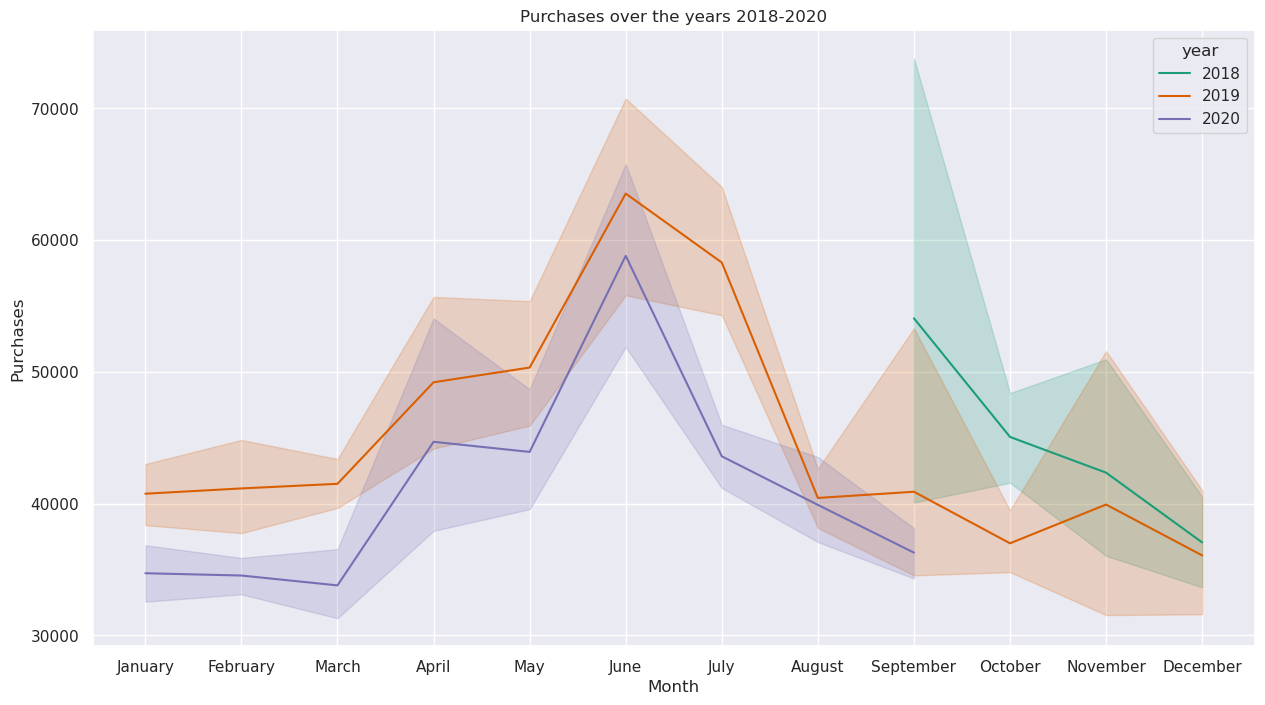

In [29]:
sns.lineplot(x="Month", y="Purchases", data=df, hue="year", palette="Dark2").set(title='Purchases over the years 2018-2020')

**Data Preprocessing**

Since we can detect a yearly sales volumn cycle from previous figure, here I'll use the data from Jan to Jun in 2019 as training dataset and data from Jan to Jun in 2020 as test and validation dataset

In [30]:
transactions_train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,0663713001,0.050831,2
1,2018-09-20,-6846340800584936,0541518023,0.030492,2
2,2018-09-20,-8334631767138808638,0505221004,0.015237,2
3,2018-09-20,-8334631767138808638,0685687003,0.016932,2
4,2018-09-20,-8334631767138808638,0685687004,0.016932,2


In [31]:
def query_based_on_date(df, start, end):
    x = df[(df['t_dat']>start) & (df['t_dat']<=end)]
    return x

In [32]:
train_x = query_based_on_date(transactions_train_df,"2019-01-01","2019-07-01")
train_x.shape

(8699838, 5)

In [33]:
test_x = query_based_on_date(transactions_train_df,"2020-01-01","2020-07-01")
test_x.shape

(7639852, 5)

In [34]:
train_x.head()

,t_dat,customer_id,article_id,price,sales_channel_id
4429407,2019-01-02,-1485175539946425831,0712519001,0.042356,1
4429408,2019-01-02,-1485175539946425831,0673677002,0.016932,1
4429409,2019-01-02,-1485175539946425831,0574069004,0.018627,1
4429410,2019-01-02,-1324432869547582252,0509629008,0.016932,2
4429411,2019-01-02,-1324432869547582252,0464908039,0.016932,2


**Check the customers that existing in both train and test data set**

In [35]:
train_customers = set(train_x["customer_id"].unique().tolist())
print(len(train_customers))

731691


In [36]:
test_customers= set(test_x["customer_id"].unique().tolist())
print(len(test_customers))

732369


In [37]:
overlap = train_customers.intersection(test_customers)
print(len(overlap))

433832


In [38]:
remove = test_customers - overlap

test_customers-=remove

print(len(test_customers))

433832


In [39]:
test_x1 =test_x[test_x["customer_id"].isin(overlap)==True]
test_x1.shape

(5723393, 5)

**Separate half of the test dataset into validation data set**

In [40]:
test_x2 = test_x1.sample(frac=0.5)
test_x2.shape

(2861696, 5)

In [41]:
val_x = test_x1.drop(test_x2.index)
val_x.shape

(2861697, 5)

**Collaborative Filtering:
Collaborative Filtering methods make recommendations by identifying patterns and similarities among users or items. There are two main subtypes:**

User-Based Collaborative Filtering: This approach recommends items based on the preferences of similar users. If User A and User B have liked similar items in the past, recommendations for User A might include items that User B has liked.**

In [42]:
ALL_USERS = customers_df['customer_id'].unique().tolist()
ALL_ITEMS = articles_df['article_id'].unique().tolist()

#user_to_customer_map = {user_id: customer_id for user_id, customer_id in enumerate(ALL_USERS)}:
#This line creates a dictionary called user_to_customer_map where the keys are user IDs (0, 1, 2, ...) 
#and the values are corresponding customer IDs from the ALL_USERS list. T
#he enumerate() function is used to iterate over the ALL_USERS list and generate pairs of user IDs and customer IDs.
user_to_customer_map = {user_id: customer_id for user_id, customer_id in enumerate(ALL_USERS)}
customer_to_user_map = {customer_id: user_id for user_id, customer_id in enumerate(ALL_USERS)}

item_to_article_map = {item_id: article_id for item_id, article_id in enumerate(ALL_ITEMS)}
article_to_item_map = {article_id: item_id for item_id, article_id in enumerate(ALL_ITEMS)}




In [43]:
customers_df['user_id'] = customers_df['customer_id'].map(customer_to_user_map)
articles_df['item_id'] = articles_df['article_id'].map(article_to_item_map)


In [44]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,user_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,2
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,3
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,4


**Build model
Configuration parameters
Since UUCF is very computationally expensive, we will apply it only to a small subset of users. The hope is that, for those users, the recommendation are better than the other models.**

We will reduce the data from 2 fronts:

Keep only the most recent history. That is START_DATE.
Keep only users with at least MINIMUM_PURCHASES**

In [45]:
test_x

,t_dat,customer_id,article_id,price,sales_channel_id
20820952,2020-01-02,-5688425581686523098,0797565002,0.030492,2
20820953,2020-01-02,-5688425581686523098,0797565001,0.030492,2
20820954,2020-01-02,3559699621668881246,0801865004,0.018627,1
20820955,2020-01-02,2031109712403594656,0578752001,0.020322,2
20820956,2020-01-02,2031109712403594656,0578752001,0.020339,2
...,...,...,...,...,...
28460799,2020-07-01,2437882347136095867,0852584001,0.033881,2
28460800,2020-07-01,5936707076301320242,0871581001,0.014220,2
28460801,2020-07-01,5936707076301320242,0859400007,0.030492,2
28460802,2020-07-01,5936707076301320242,0682236023,0.021339,2


_______________________________________________

**The plan is:**

**1. implement a quick training pipeline leading to good validation**

**2. train a ranking model on candidates we know to be good**

**3. only generate new training data / candidates while validating whether we are moving in the right direction using local CV**

**4. start with building sensible features and see whether they move the needle on the score**

In [46]:
!wget https://raw.githubusercontent.com/benhamner/Metrics/master/Python/ml_metrics/average_precision.py
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from average_precision import apk

# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

--2023-08-25 15:40:30--  https://raw.githubusercontent.com/benhamner/Metrics/master/Python/ml_metrics/average_precision.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1654 (1.6K) [text/plain]
Saving to: ‘average_precision.py’

average_precision.p 100%[===================>]   1.62K  --.-KB/s    in 0s      

2023-08-25 15:40:30 (19.6 MB/s) - ‘average_precision.py’ saved [1654/1654]



In [47]:
%%time
import pandas as pd

articles = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv", dtype={"article_id": "str"})
customers = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions= pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv", dtype={"article_id": "str"})


CPU times: user 50.7 s, sys: 7.21 s, total: 57.9 s
Wall time: 1min 1s


In [48]:
transactions.memory_usage(deep=True)

Index                      128
t_dat               2129817708
customer_id         3846387204
article_id          2129817708
price                254306592
sales_channel_id     254306592
dtype: int64

In [49]:
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        object 
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 8.0 GB


In [50]:
%%time
transactions['customer_id'].nunique()

CPU times: user 8.98 s, sys: 173 ms, total: 9.16 s
Wall time: 9.14 s


1362281

In [51]:

transactions.memory_usage(deep=True)

Index                      128
t_dat               2129817708
customer_id         3846387204
article_id          2129817708
price                254306592
sales_channel_id     254306592
dtype: int64

In [52]:

transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        object 
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 8.0 GB


**

Initially, I wanted to get rid of the t_dat column but on second thought I am not a fan.

I am all for speed and reducing weight, but the main purpose of this activity is to increase developer productivity.

If I fall back down to ints representing year, week, day I will be certainly trading developer productivity for fewer CPU cycles that are needed (and I want to go in the exact opposite direction! developer productivity > (nearly) anything else)**

In [53]:
transactions.t_dat = pd.to_datetime(transactions.t_dat, format='%Y-%m-%d')

In [54]:
transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

In [55]:
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        object        
 3   price             float64       
 4   sales_channel_id  int64         
 5   week              int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.5 GB


In [56]:
transactions.article_id = article_id_str_to_int(transactions.article_id)
articles.article_id = article_id_str_to_int(articles.article_id)

transactions.week = transactions.week.astype('int8')
transactions.sales_channel_id = transactions.sales_channel_id.astype('int8')
transactions.price = transactions.price.astype('float32')


In [57]:

transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int32         
 3   price             float32       
 4   sales_channel_id  int8          
 5   week              int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), object(1)
memory usage: 4.1 GB


In [58]:

transactions.drop(columns='t_dat').info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   customer_id       object 
 1   article_id        int32  
 2   price             float32
 3   sales_channel_id  int8   
 4   week              int8   
dtypes: float32(1), int32(1), int8(2), object(1)
memory usage: 3.9 GB


In [59]:

customers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 512.3 MB


In [60]:

articles.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int32 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

**Well, this stuff will be getting merged with our transactions df at some point, so I guess we can also make this smaller and easier to work with down the road.**

In [61]:
customers['club_member_status'].unique()


array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [62]:
customers.customer_id = customer_hex_id_to_int(customers.customer_id)
for col in ['FN', 'Active', 'age']:
    customers[col].fillna(-1, inplace=True)
    customers[col] = customers[col].astype('int8')

In [63]:
customers.club_member_status = Categorize().fit_transform(customers[['club_member_status']]).club_member_status
customers.postal_code = Categorize().fit_transform(customers[['postal_code']]).postal_code
customers.fashion_news_frequency = Categorize().fit_transform(customers[['fashion_news_frequency']]).fashion_news_frequency

In [64]:
customers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   customer_id             1371980 non-null  uint64
 1   FN                      1371980 non-null  int8  
 2   Active                  1371980 non-null  int8  
 3   club_member_status      1371980 non-null  int8  
 4   fashion_news_frequency  1371980 non-null  int8  
 5   age                     1371980 non-null  int8  
 6   postal_code             1371980 non-null  int32 
dtypes: int32(1), int8(5), uint64(1)
memory usage: 22.2 MB


In [65]:
for col in articles.columns:
    if articles[col].dtype == 'object':
        articles[col] = Categorize().fit_transform(articles[[col]])[col]

In [66]:
articles.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int32
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  int32
 3   product_type_no               105542 non-null  int64
 4   product_type_name             105542 non-null  int16
 5   product_group_name            105542 non-null  int8 
 6   graphical_appearance_no       105542 non-null  int64
 7   graphical_appearance_name     105542 non-null  int8 
 8   colour_group_code             105542 non-null  int64
 9   colour_group_name             105542 non-null  int8 
 10  perceived_colour_value_id     105542 non-null  int64
 11  perceived_colour_value_name   105542 non-null  int8 
 12  perceived_colour_master_id    105542 non-null  int64
 13  perceived_colo

In [67]:
for col in articles.columns:
    if articles[col].dtype == 'int64':
        articles[col] = articles[col].astype('int32')

In [68]:
transactions.sort_values(['t_dat', 'customer_id'], inplace=True)

In [69]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
  



In [70]:
transactions.to_parquet('data/transactions_train.parquet')
customers.to_parquet('data/customers.parquet')
articles.to_parquet('data/articles.parquet')

**Let's also generate a sample we will be able to use to speed up development.**

In [71]:
%%time
# let's create a 5% sample of the entiriety of the data to speed up dev

sample = 0.05
customers_sample = customers.sample(frac=sample, replace=False)
customers_sample_ids = set(customers_sample['customer_id'])
transactions_sample = transactions[transactions["customer_id"].isin(customers_sample_ids)]
articles_sample_ids = set(transactions_sample["article_id"])
articles_sample = articles[articles["article_id"].isin(articles_sample_ids)]

customers_sample.to_parquet(f'data/customers_sample_{sample}.parquet', index=False)
transactions_sample.to_parquet(f'data/transactions_train_sample_{sample}.parquet', index=False)
articles_sample.to_parquet(f'data/articles_train_sample_{sample}.parquet', index=False)

CPU times: user 3.74 s, sys: 301 ms, total: 4.04 s
Wall time: 3.77 s


In [72]:
from collections import defaultdict

val_week_purchases_by_cust = defaultdict(list)

val_week_purchases_by_cust.update(
    transactions[transactions.week == transactions.week.max()] \
        .groupby('customer_id')['article_id'] \
        .apply(list) \
        .to_dict()
)

pd.to_pickle(dict(val_week_purchases_by_cust), 'data/val_week_purchases_by_cust.pkl')

sample_sub = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
valid_gt = customer_hex_id_to_int(sample_sub.customer_id) \
    .map(val_week_purchases_by_cust) \
    .apply(lambda xx: ' '.join('0' + str(x) for x in xx))

sample_sub.prediction = valid_gt
sample_sub.to_parquet('data/validation_ground_truth.parquet', index=False)


In [73]:
from average_precision import apk

def calculate_apk(list_of_preds, list_of_gts):
    # for fast validation this can be changed to operate on dicts of {'cust_id_int': [art_id_int, ...]}
    # using 'data/val_week_purchases_by_cust.pkl'
    apks = []
    for preds, gt in zip(list_of_preds, list_of_gts):
        apks.append(apk(gt, preds, k=12))
    return np.mean(apks)

def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_parquet('data/validation_ground_truth.parquet')

    apks = []

    no_purchases_pattern = []
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases and (gt == no_purchases_pattern): continue
        apks.append(apk(gt, pred, k=12))
    return np.mean(apks)

**We need to:**

**find a way to structure candidates so that they could be fed into a ranking model

create features that would capture the information the kernel is relying on

first output the predictions manually (hardcode a ranking model) and subsequently feed the data to a ranker**


predict on candidates

if for some customer the predictions are in some sense not reliable enough, or the likelihood of a sale is to low, use the bestseller logic from the kaggle kernel.

In [74]:
final_week = transactions[transactions.week == transactions.week.max()]

In [75]:
final_week['customer_id'].value_counts().describe()

count    68984.000000
mean         3.483576
std          3.535144
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        104.000000
Name: customer_id, dtype: float64

In [76]:
bestsellers_last_week = set(transactions[transactions.week == transactions.week.max()].article_id.value_counts().index[:12])
bestsellers_week_ago = set(transactions[transactions.week == transactions.week.max()-1].article_id.value_counts().index[:12])

In [77]:
final_week.article_id.isin(bestsellers_last_week).mean(), final_week.article_id.isin(bestsellers_week_ago).mean()

(0.027967924897320556, 0.02349871624686344)

In [78]:
without_final_week = transactions[transactions.week != transactions.week.max()]

In [79]:
unique_bought_items = 0
last_purchase_repeated = 0
purchases_cust_with_no_history = 0
items_purchased_by_custs_with_no_history = []
week_of_earlier_purchase = []
i = 0

for c_id, df in final_week.groupby('customer_id'):
    purchases_final_week = set(df.article_id)
    unique_bought_items += len(purchases_final_week)
    
    purchase_history = without_final_week[without_final_week.customer_id == c_id]
    purchases_before = set(purchase_history[purchase_history.week == purchase_history.week.max()].article_id)
    week_of_earlier_purchase.append(purchase_history.week.max())
    
    if len(purchases_before) == 0:
        purchases_cust_with_no_history += len(purchases_final_week)
        items_purchased_by_custs_with_no_history += list(purchases_final_week)
    else:
        last_purchase_repeated += len(purchases_final_week.intersection(purchases_before))
    i += 1
    if i == 1000: break